In [4]:
import numpy as np

# Import local plotting functions and in-notebook display functions
import matplotlib.pyplot as plt
%matplotlib inline


# Numerical integration

We are want to solve problems of the form

$$\frac{d\mathbf{y}}{dt} = \mathbf{f}(t, \mathbf{y})$$

where $\mathbf{y}$ is a vector of unknowns.  We can do this by discretizing time.

### Relationship to optimization

+ Every optimization problem can be written as an ODE for potential flow. However, not every ODE can be written as an optimization problem.
+ Limit cycles, chaos, and other interesting phenomena can be found in ODEs, but not in optimization problems, because potential flows have zero curl
+ While we cannot always define a potential function for a given set of ODEs, the gradient and the Hessian are still well-defined. In an ODE context, the gradient is just the right-hand side of the ODE, $\frac{d\mathbf{y}}{dt}$, and the Hessian corresponds to the Jacobian matrix of the right-hand side.

$$
\mathbb{J} = \frac{\partial \dot{\mathbf{y}}}{\partial \mathbf{y}} = \frac{\partial \mathbf{f}}{\partial \mathbf{y}}
$$

Writing this out,
$$
\mathbb{J} = \begin{bmatrix}
\frac{\partial f_1}{\partial y_1} & \frac{\partial f_1}{\partial y_2} & \cdots & \frac{\partial f_1}{\partial y_n} \\
\frac{\partial f_2}{\partial y_1} & \frac{\partial f_2}{\partial y_2} & \cdots & \frac{\partial f_2}{\partial y_n} \\
\vdots & \vdots & \ddots & \vdots \\
\frac{\partial f_n}{\partial y_1} & \frac{\partial f_n}{\partial y_2} & \cdots & \frac{\partial f_n}{\partial y_n}
\end{bmatrix}
$$

Just as we saw in optimization, stepping the right-hand side is always necessary to find the next step in the solution. Knowledge of the Jacobian can improve convergence and stability, as well as reveal mathemtical properties of the ODE solution.

<!-- $$
\frac{d\mathbf{y}}{dt} = \mathbb{J} \mathbf{y} -->

# The Thomas Model

Let's use a well-known set of coupled differential equations to demonstrate our numerical integration schemes
$$
\dot{x} = \sin(y) - b x     \\
\dot{y} = \sin(z) - b y     \\
\dot{z} = \sin(x) - b z     \\
$$
These equations describe the motion of a particle confined in a 3D harmonic potential, subject to a periodic lattice of dispersive forces.


### An initial value problem

In numerical integration, we are usually given an initial condition $\mathbf{x}(0)$ and asked to find $\mathbf{x}(t)$ for some $t > 0$. 



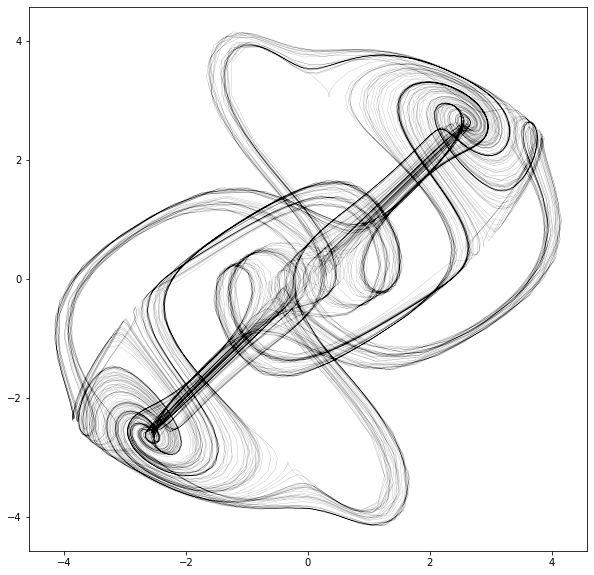

In [32]:
def thomas_model(t, X, b=0.185):
    """
    Thomas dynamical model
    """
    x, y, z = X
    xdot = np.sin(y) - b * x
    ydot = np.sin(z) - b * y
    zdot = np.sin(x) - b * z
    return [xdot, ydot, zdot]

# Let's cheat and integrate the ODE using scipy.integrate.solve_ivp

from scipy.integrate import solve_ivp
ic = [0.21, 0.3, 0.4]
t = np.linspace(0, 6000, 10000)
sol = solve_ivp(thomas_model, [t[0], t[-1]], ic, t_eval=t)
X = sol.y.T


plt.figure(figsize=(10, 10))
plt.plot(X[:, 0], X[:, 1], linewidth=0.1, color='k', alpha=1.0)

## Explicit fixed-step integrators


+ The Euler method is the simplest explicit fixed-step integrator. It is a first-order method, and is unconditionally stable for a sufficiently small step size. It is also the most computationally efficient method per evaluation, but it is also the least accurate.

In [ ]:

class BaseFixedStepIntegrator:
    """
    A base class for fixed-step integration methods.
    """
    def __init__(self, dt=1e-3):
        self.dt = dt
        self.name = self.__class__.__name__
        

class Euler(BaseFixedStepIntegrator):
    """
    Note:
    super() calls the constructor of BaseIntegrator
    kwargs get passed on to the constructor of BaseIntegrator
    """
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        
    def integrate(self, f, t0, y0, t1):
        """
        Integrate the ODE y' = f(t, y) from t0 to t1 using Euler's method.
        """
        t = np.arange(t0, t1, self.dt)
        n = len(t)
        y = np.zeros((n + 1, y0.shape[-1]))
        y[0] = y0
        print(y[0])
        for i in range(n):
            y[i + 1] = y[i] + self.dt * f(t[i], y[i])
        return t, y

class RungeKutta(BaseFixedStepIntegrator):

    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def integrate(self, f, t0, y0, t1):
        t = np.arange(t0, t1, self.dt)
        n = len(t)
        y = np.zeros((n + 1, y0.shape[-1]))
        y[0] = y0
        for i in range(n):
            k1 = f(t[i], y[i])
            k2 = f(t[i] + 0.5 *  self.dt, y[i] + 0.5 *  self.dt * k1)
            k3 = f(t[i] + 0.5 *  self.dt, y[i] + 0.5 *  self.dt * k2)
            k4 = f(t[i] + self.dt, y[i] + self.dt * k3)
            y[i + 1] = y[i] + self.dt / 6 * (k1 + 2 * k2 + 2 * k3 + k4)
        return t, y


class DormandPrince(BaseFixedStepIntegrator):

    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def integrate(self, f, t0, y0, t1):
        t = np.arange(t0, t1, self.dt)
        h = self.dt
        n = len(t)
        y = np.zeros((n + 1, y0.shape[-1]))
        y[0] = y0
        for i in range(n):
            k1 = f(t[i], y[i])
            k2 = f(t[i] + 0.25 * h, y[i] + 0.25 * h * k1)
            k3 = f(t[i] + (3 / 8) * h, y[i] + (3 / 32) * h * k1 + (9 / 32) * h * k2)
            k4 = f(t[i] + (12 / 13) * h, y[i] + (1932 / 2197) * h * k1 - (7200 / 2197) * h * k2 + (7296 / 2197) * h * k3)
            k5 = f(t[i] + h, y[i] + (439 / 216) * h * k1 - 8 * h * k2 + (3680 / 513) * h * k3 - (845 / 4104) * h * k4)
            k6 = f(t[i] + (1 / 35) * h, y[i] - (8 / 27) * h * k1 + 2 * h * k2 - 3544 / 2565 * h * k3 + 1859 / 4104 * h * k4 - 11 / 40 * h * k5)
            y[i + 1] = y[i] + (25 / 216) * h * k1 + 1408 / 2565 * h * k3 + 2197 / 4104 * h * k4 - 1 / 5 * h * k5
        return t, y


## Butcher Tableau

A recursive set of definitions for the coefficients in explicit Runge-Kutta methods

<!-- \begin{array} {c|cccc} 0\\ 1/2 & 1/2\\ 1/2 &0 &1/2 \\ 1& 0& 0& 1\\ \hline & 1/6 & 1/3 & 1/3 &1/6 \end{array}

\begin{array} {c|cccc} 0\\ 1/3 & 1/3\\ 2/3 & -1/3 &1 \\ 1& 1& -1 & 1\\ \hline & 1/8 & 3/8 & 3/8 &1/8 \end{array}

\begin{array} {c|ccccc} 0\\ c_2 & a_{21}\\ c_3 & a_{31} & a_{32} \\ \vdots & \vdots & & \ddots \\ c_s& a_{s1}& a_{s2} & \cdots & a_{s,s-1}\\ \hline & b_1 & b_2 & \cdots & b_{s-1} & b_s \end{array}

 -->

$$
y' = f(t, y)
$$

$$
y_{n+1} = y_n + \frac{h}{6}\left( k_{n1} + 2k_{n2} + 2k_{n3} + k_{n4}\right)
$$


k_{n1} &=& f(t_n, y_n) \\ 
k_{n2} &=& f(t_n + 0.5h, y_n + 0.5hk_{n1}) \\ 
k_{n3} &=& f(t_n + 0.5h, y_n + 0.5hk_{n2}) \\
k_{n4} &=& f(t_n + h, y_n + hk_{n3}) \\


<!-- k_{n1} &=& f(t_n, y_n) \\ k_{n2} &=& f(t_n + 0.5h, y_n + 0.5hk_{n1}) \\ k_{n3} &=& f(t_n + 0.5h, y_n + 0.5hk_{n2}) \\ k_{n4} &=& f(t_n + h, y_n + hk_{n3}) \\ -->

## Runge-Kutta methods

$$
k_{ni} = f\left(x_n + c_i h, y_n + h \sum_{j=1}^s a_{ij} k_{nj}\right)
$$

#### Euler's method (forward step)

\begin{array} 
{c|c} 0 & 0\\ \hline & 1
\end{array}

#### Euler's method (backward step)

\begin{array} 
{c|c} 1 & 1\\ \hline & 1
\end{array}





\begin{array} {c|ccccc} c_1 & a_{11} & a_{12} & \cdots & a_{1s} \\ c_2 & a_{21} & a_{22} & \cdots & a_{2s} \\ \vdots & \vdots & & \ddots & \vdots \\ c_s& a_{s1}& a_{s2} & \cdots & a_{s,s}\\ \hline & b_1 & b_2 & \cdots & b_{s} \end{array}


Notes here:
https://www.johndcook.com/blog/2020/02/13/runge-kutta-methods/

## The implicit Euler method

# The Butcher Tableau, Implicit

# Linear multistep

# Variable step

# Symplectic

When we have an explict conserved quantity, many of the above methods will fail

